1.feedforward network（densely connected networks, convnetsなど）の特徴：no memory, no state kept in between inputs。<br> With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. <br>
2.The state of the RNN is reset between processing two different, independent sequences (such as two different IMDB reviews), so you still consider one sequence a single data point: a single input to the network.

## Numpy implementation of a simple RNN
ほぼKerasのSimpleRNN layerの実現

In [17]:
import numpy as np

def numpyImplementationRNN():
    timesteps = 100
    input_features = 32
    output_features = 64
    
    inputs = np.random.random((timesteps, input_features))
    
    state_t = np.zeros((output_features,))
    
    W = np.random.random((output_features, input_features))
    U = np.random.random((output_features, output_features))
    b = np.random.random((output_features,))
    
    successive_outputs = []
    for input_t in inputs:
        output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
        successive_outputs.append(output_t)
        state_t = output_t
    
    #本にはnp.concatenateを使っているが、shapeが(6400,)になっちゃう
    final_output_sequence = np.asarray(successive_outputs)
    return final_output_sequence

numpyImplementationRNN().shape

(100, 64)

# 6.2.1 A recurrent layer in Keras

## Using Embedding and SimpleRNN layers on IMDB movie-review-classification problem

In [19]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500

(input_train, y_train), (input_test, y_test) = imdb.load_data(
    num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

25000 train sequences
25000 test sequences
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [21]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
# defaultは最後のoutputだけ出力する。つまり(batch_size, output_features).
# return_sequences=Trueで全てタイミングのoutputを出せる。つまり(batch_size, timesteps, output_features).
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 18s 924us/step - loss: 0.6420 - acc: 0.6150 - val_loss: 0.6567 - val_acc: 0.5996
Epoch 2/10
20000/20000 [==============================] - 18s 899us/step - loss: 0.4257 - acc: 0.8139 - val_loss: 0.4046 - val_acc: 0.8362
Epoch 3/10
20000/20000 [==============================] - 19s 941us/step - loss: 0.3225 - acc: 0.8705 - val_loss: 0.4258 - val_acc: 0.8084
Epoch 4/10
20000/20000 [==============================] - 19s 931us/step - loss: 0.2468 - acc: 0.9053 - val_loss: 0.3460 - val_acc: 0.8586
Epoch 5/10
20000/20000 [==============================] - 23s 1ms/step - loss: 0.1917 - acc: 0.9298 - val_loss: 0.3918 - val_acc: 0.8628
Epoch 6/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.1384 - acc: 0.9513 - val_loss: 0.4654 - val_acc: 0.8058
E

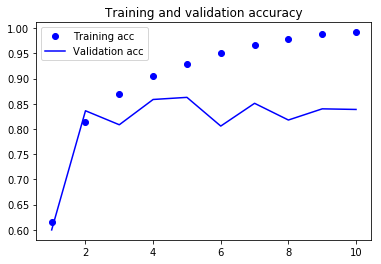

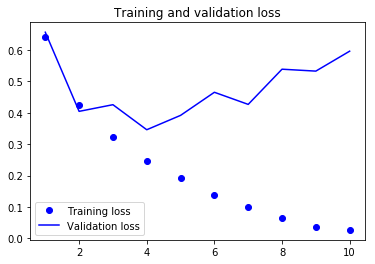

In [23]:
def plotAccAndLoss():
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
plotAccAndLoss()

結果についての説明：<br>
Chapter3の全結合ネットワークの結果の方が良い(val_acc 88%)。理由は2つある。まず、SimpleRNNは500長さのデータしか見ていない。全結合は全部見た。また、SimpleRNNは長いsequenceを処理するのに得意じゃない。これからLSTMとGRU層を使ってみる。

# 6.2.2 Understanding the LSTM and GRU layers
1.SimpleRNNが弱い原因：long-term dependenciesを学習できない。LSTMとGRUが長期依頼問題を解決する。<br>
2.long-term dependenciesを学習できない理由：vanishing gradient problem.<br>
3.LSTMの解決方法：add a way to carry information across many timesteps.

この部分のLSTMに関する説明に少し疑問を持っているので、下記のところに詳しく書いてみた。<br>
[KerasのLSTM実現についての疑問](https://qiita.com/youngsend/items/c442a392f243119da400)

# 6.2.3 A concrete LSTM example in Keras

In [25]:
from keras.layers import LSTM

model = Sequential()
# embeddings dimensionalityとLSTM output dimensionalityなどのhyperparametersはチューニングしていない
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 245s 12ms/step - loss: 0.4314 - acc: 0.8047 - val_loss: 0.2921 - val_acc: 0.8832
Epoch 2/10
20000/20000 [==============================] - 244s 12ms/step - loss: 0.2641 - acc: 0.8978 - val_loss: 0.4211 - val_acc: 0.8754
Epoch 3/10
20000/20000 [==============================] - 245s 12ms/step - loss: 0.2218 - acc: 0.9153 - val_loss: 0.2665 - val_acc: 0.8924
Epoch 4/10
20000/20000 [==============================] - 260s 13ms/step - loss: 0.1973 - acc: 0.9277 - val_loss: 0.2870 - val_acc: 0.8806
Epoch 5/10
20000/20000 [==============================] - 246s 12ms/step - loss: 0.1831 - acc: 0.9347 - val_loss: 0.3224 - val_acc: 0.8838
Epoch 6/10
20000/20000 [==============================] - 245s 12ms/step - loss: 0.1694 - acc: 0.9407 - val_loss: 0.3004 - val_acc: 0.8812
Epoch 7/10
20000/20000 [==============================] - 244s 12ms/step - loss: 0.1559 - acc: 0.9434 - val_loss: 0.3

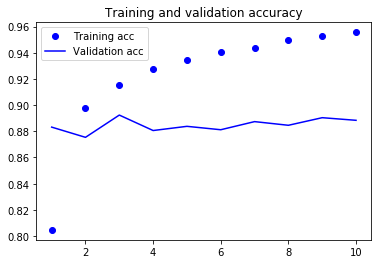

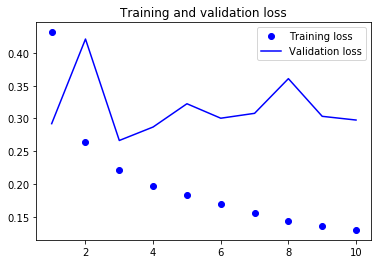

In [26]:
plotAccAndLoss()

SimpleRNNの結果（83%）より良くなった（89%）が、トレーニング時間はめっちゃ長くなった。<br>
**LSTM layerを使ったら、GPUを使った方がいいと分かった**。
また、上記の簡単なトレーニング、僕のMacProでは28%のbatteryが掛かった。<br>
なぜ結果が89%以上に行かない説明：The primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn't helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review. But there are far more difficult natural-language-processing problems out there, where the strength of LSTM will become apparent: in particular, question-answering and machine translation.